In [ ]:
# imputation by interpolate performs better than other methods -median amd mode
#XGB performs better than RF
# scaling does not improve the performance
# Important features are found using Lasso regression works fine for linear relationship
# Through XGB important variables are found for both CO_HMI and NOX_HMI cols
# Trying grid search and randomized search taking a lot of time -hours

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
#from sklearn.ensemble import StackingRegressor

from sklearn.multioutput import MultiOutputRegressor
import xgboost as xgb
#from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score,mean_squared_error
import math

In [4]:
# read the respective files from these locations
data_file_training='/data-restricted/PEM/L0162_20200909T0001_20201201T1230.csv'
df = pd.read_csv(data_file_training)
print(df.shape)
print(list(df.columns))

FileNotFoundError: [Errno 2] No such file or directory: '/data-restricted/PEM/L0162_20200909T0001_20201201T1230.csv'

In [4]:
#output_columns=['NOX_HMI', 'CO_HMI'] #compare your predictions with 'NOX15', 'CO15'
df.drop(['NOX15','CO15'],axis=1,inplace=True)

In [5]:
df['Timestamp']=pd.to_datetime(df['Timestamp'])
df=df.set_index('Timestamp')

In [ ]:
#df[df.columns].apply(lambda x: x.corr(df['CO_HMI']))
#df[df.columns].apply(lambda x: x.corr(df['NOX_HMI']))

In [6]:
cols_with_NaNs=df.columns[df.isnull().any()].tolist()
cols_with_NaNs

['PX36AVAL', 'PX36BVAL', 'EMISSIONS_SS']

array([[<AxesSubplot:title={'center':'BRNDMD'}>,
        <AxesSubplot:title={'center':'WFPILM'}>,
        <AxesSubplot:title={'center':'F_FARFLI'}>,
        <AxesSubplot:title={'center':'F_FARFLO'}>,
        <AxesSubplot:title={'center':'F_FARFL'}>,
        <AxesSubplot:title={'center':'F_W2'}>,
        <AxesSubplot:title={'center':'F_WA36'}>],
       [<AxesSubplot:title={'center':'F_WB3Q'}>,
        <AxesSubplot:title={'center':'F_WF36DMD'}>,
        <AxesSubplot:title={'center':'P2SEL'}>,
        <AxesSubplot:title={'center':'PS3SEL'}>,
        <AxesSubplot:title={'center':'T2SEL'}>,
        <AxesSubplot:title={'center':'T3SEL'}>,
        <AxesSubplot:title={'center':'TFLCYCS'}>],
       [<AxesSubplot:title={'center':'TFLPDFS'}>,
        <AxesSubplot:title={'center':'TFLIDFS'}>,
        <AxesSubplot:title={'center':'TFLODFS'}>,
        <AxesSubplot:title={'center':'WFINRM'}>,
        <AxesSubplot:title={'center':'WFOTRM'}>,
        <AxesSubplot:title={'center':'WFQPERRCOR'}>,
       

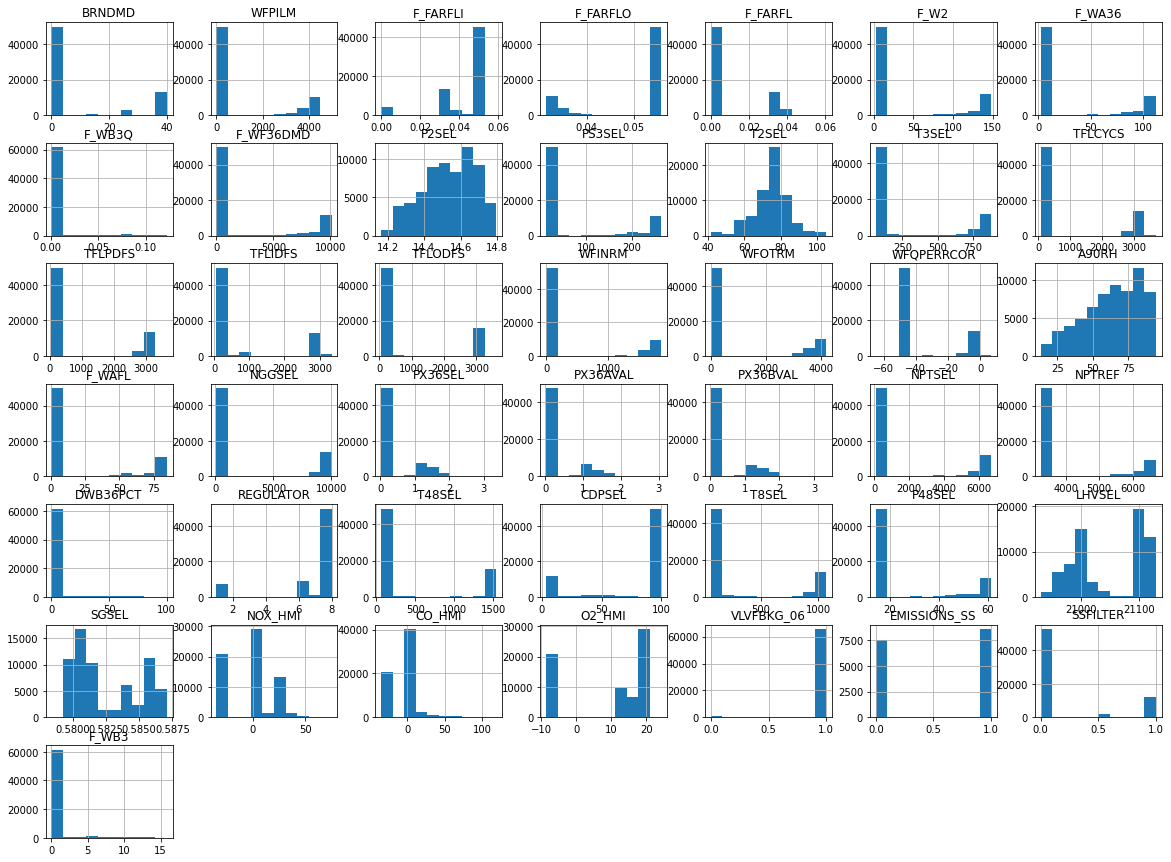

In [7]:
df.hist(figsize=(20,15))

In [8]:
#imputation by interpolate method
df['PX36AVAL']=df['PX36AVAL'].interpolate(method='linear')
df['PX36BVAL']=df['PX36BVAL'].interpolate(method='linear')
#There are no null values

In [9]:
#since 75% if this variable are NaNs
df.drop(('EMISSIONS_SS'),axis=1,inplace=True)

In [10]:
df.isnull().sum().any()

False

In [11]:
#train and test split
train_df,test_df=df[:46428],df[46428:]
print(train_df.shape,test_df.shape)

(46428, 42) (19903, 42)


## do feature scaling and get the performance 

In [12]:
#feature scaling
train_vars=[var for var in train_df.columns if var not in ['NOX_HMI', 'CO_HMI']]
#create scaler
scaler=MinMaxScaler()
#fit the scaler to the train set
scaler.fit(train_df[train_vars])
# transform the train and the test set
train_df[train_vars]=scaler.transform(train_df[train_vars])
test_df[train_vars]=scaler.transform(test_df[train_vars])

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3673: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3673: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [14]:
#train_df.hist(figsize=(20,10))

In [15]:
OUTPUT_COLUMNS=['NOX_HMI','CO_HMI']
train_X=train_df.drop(OUTPUT_COLUMNS,axis=1)
train_y=train_df[OUTPUT_COLUMNS]
test_X=test_df.drop(OUTPUT_COLUMNS,axis=1)
test_y=test_df[OUTPUT_COLUMNS]

In [16]:
sel_ = SelectFromModel(Lasso(alpha=0.005,random_state=0))
#train lasso model and select features
sel_.fit(train_X,train_y)
#print the number of total and selected features
selected_feats=train_X.columns[(sel_.get_support())]
#statistics of the features
print('Total features: {}'.format((train_X.shape[1])))
print('selected features: {}'.format(len(selected_feats)))
print('features with coefficients sharank to zero: {}'.format(np.sum(sel_.estimator_.coef_==0)))

Total features: 40
selected features: 29
features with coefficients sharank to zero: 45


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 379354.60627975187, tolerance: 1731.5385843402412
  model = cd_fast.enet_coordinate_descent(


In [18]:
selected_feats

Index(['BRNDMD', 'WFPILM', 'F_FARFLO', 'F_FARFL', 'F_W2', 'F_WB3Q',
       'F_WF36DMD', 'P2SEL', 'T2SEL', 'T3SEL', 'TFLCYCS', 'TFLIDFS', 'TFLODFS',
       'WFINRM', 'WFOTRM', 'A90RH', 'PX36SEL', 'PX36AVAL', 'NPTREF',
       'DWB36PCT', 'REGULATOR', 'CDPSEL', 'T8SEL', 'P48SEL', 'LHVSEL', 'SGSEL',
       'O2_HMI', 'VLVFBKG_06', 'SSFILTER'],
      dtype='object')

In [23]:
train_y.columns

Index(['NOX_HMI', 'CO_HMI'], dtype='object')

In [ ]:
#with lasso after rescaling and all features
##lasso
Root_mean_squared_error_test set 7.94650850612373
R2 Score_test set 0.7806846064304057
# include selected features
Root_mean_squared_error_test set 9.287444536571622
R2 Score_test set 0.6905458903064012
##RF

In [21]:
lin_model=Lasso(alpha=0.005,random_state=0)
model1=lin_model.fit(train_X[selected_feats],train_y)
predictions_lasso=model1.predict(test_X[selected_feats])
#for test set
print('Root_mean_squared_error_test set',math.sqrt(mean_squared_error(test_y,predictions_lasso)))
print('R2 Score_test set',r2_score(test_y,predictions_lasso))

Root_mean_squared_error_test set 9.287444536571622
R2 Score_test set 0.6905458903064012


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 380668.429849108, tolerance: 1731.5385843402412
  model = cd_fast.enet_coordinate_descent(


### Apply different models linear and non-linear 

In [27]:
#with 400 trees error is 9.28
# with selected features 100 trees error is same
RF_model=RandomForestRegressor(n_estimators=100,random_state=0)
model2=RF_model.fit(train_X,train_y)
predictions_RF=model2.predict(test_X)
#for test set
print('Root_mean_squared_error_test set',math.sqrt(mean_squared_error(test_y,predictions_RF)))
print('R2 Score_test set',r2_score(test_y,predictions_RF))


Root_mean_squared_error_test set 4.938363291838102
R2 Score_test set 0.9215976718077572


In [30]:
#changed the estimators to 100 and depth 12 lr=.1 4.3604 0.937
other_params={'learning_rate':0.05,'n_estimators':50,'max_depth':12,'min_child_weight':1,'subsample':0.8,'colsample_bytree':0.8}

multioutputregressor=MultiOutputRegressor(xgb.XGBRegressor(objective='reg:squarederror',**other_params)).fit(train_X,train_y)

predictions=multioutputregressor.predict(test_X)

#for test set
print('Root_mean_squared_error_test set',math.sqrt(mean_squared_error(test_y,predictions)))
print('R2 Score_test set',r2_score(test_y,predictions))

Root_mean_squared_error_test set 4.593399106402547
R2 Score_test set 0.9409580860964399


In [49]:
train_y.head(2)

,NOX_HMI,CO_HMI
Timestamp,,
2020-09-09 00:01:00,0.088763,-0.143556
2020-09-09 00:02:00,0.009912,-0.143507


In [46]:
len(multioutputregressor.estimators_)

2

In [61]:
NOX_HMI=multioutputregressor.estimators_[0].feature_importances_
CO_HMI=multioutputregressor.estimators_[1].feature_importances_
feature_importances_NOX_HMI=pd.DataFrame(NOX_HMI,index=train_X.columns,columns=['importance']).sort_values('importance',ascending=False)
feature_importances_CO_HMI=pd.DataFrame(CO_HMI,index=train_X.columns,columns=['importance']).sort_values('importance',ascending=False)

<AxesSubplot:>

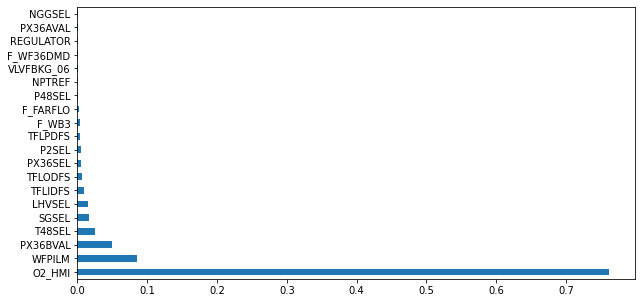

In [75]:
pd.Series(NOX_HMI, index=train_X.columns).nlargest(20).plot(kind='barh',figsize=(10,5)) 

In [67]:
feature_importances_NOX_HMI

,importance
O2_HMI,0.761220
WFPILM,0.085231
PX36BVAL,0.050231
T48SEL,0.025489
SGSEL,0.016301
LHVSEL,0.015312
TFLIDFS,0.009313
TFLODFS,0.006066
PX36SEL,0.005325
P2SEL,0.004814


In [84]:
feature_importances_CO_HMI=feature_importances_CO_HMI.sort_values('importance',ascending=False)
feature_importances_CO_HMI

,importance
REGULATOR,0.767585
F_WB3Q,0.111317
O2_HMI,0.062413
T48SEL,0.009718
WFOTRM,0.009195
F_FARFL,0.005692
WFINRM,0.004382
F_WB3,0.004298
TFLCYCS,0.004018
NPTREF,0.002753


In [70]:
common_imp_columns_all=set(feature_importances_CO_HMI.index) & set(feature_importances_NOX_HMI.index)  

In [85]:
feature_importances_CO_HMI.index[0:30]

Index(['REGULATOR', 'F_WB3Q', 'O2_HMI', 'T48SEL', 'WFOTRM', 'F_FARFL',
       'WFINRM', 'F_WB3', 'TFLCYCS', 'NPTREF', 'NPTSEL', 'SGSEL', 'TFLIDFS',
       'NGGSEL', 'LHVSEL', 'BRNDMD', 'PX36AVAL', 'WFQPERRCOR', 'DWB36PCT',
       'P2SEL', 'TFLODFS', 'PX36BVAL', 'T8SEL', 'TFLPDFS', 'PS3SEL', 'WFPILM',
       'F_WAFL', 'F_WA36', 'P48SEL', 'PX36SEL'],
      dtype='object')

In [86]:
feature_importances_NOX_HMI.index[0:30]

Index(['O2_HMI', 'WFPILM', 'PX36BVAL', 'T48SEL', 'SGSEL', 'LHVSEL', 'TFLIDFS',
       'TFLODFS', 'PX36SEL', 'P2SEL', 'TFLPDFS', 'F_WB3', 'F_FARFLO', 'P48SEL',
       'NPTREF', 'VLVFBKG_06', 'F_WF36DMD', 'REGULATOR', 'PX36AVAL', 'NGGSEL',
       'NPTSEL', 'T2SEL', 'SSFILTER', 'TFLCYCS', 'WFINRM', 'WFQPERRCOR',
       'T3SEL', 'F_FARFL', 'F_WB3Q', 'F_WA36'],
      dtype='object')

In [88]:
#ommon_important_features from top 30 features of both output columns
common_important_features=list(set(feature_importances_CO_HMI.index[0:30]) & set(feature_importances_NOX_HMI.index[0:30]))

In [90]:
print(len(common_important_features),common_important_features)

24 ['F_WA36', 'P2SEL', 'T48SEL', 'TFLPDFS', 'WFINRM', 'WFPILM', 'P48SEL', 'PX36AVAL', 'PX36SEL', 'TFLODFS', 'TFLIDFS', 'WFQPERRCOR', 'F_FARFL', 'PX36BVAL', 'LHVSEL', 'REGULATOR', 'NPTREF', 'NGGSEL', 'NPTSEL', 'F_WB3Q', 'F_WB3', 'O2_HMI', 'TFLCYCS', 'SGSEL']


In [87]:
#features from lasso
selected_feats

Index(['BRNDMD', 'WFPILM', 'F_FARFLO', 'F_FARFL', 'F_W2', 'F_WB3Q',
       'F_WF36DMD', 'P2SEL', 'T2SEL', 'T3SEL', 'TFLCYCS', 'TFLIDFS', 'TFLODFS',
       'WFINRM', 'WFOTRM', 'A90RH', 'PX36SEL', 'PX36AVAL', 'NPTREF',
       'DWB36PCT', 'REGULATOR', 'CDPSEL', 'T8SEL', 'P48SEL', 'LHVSEL', 'SGSEL',
       'O2_HMI', 'VLVFBKG_06', 'SSFILTER'],
      dtype='object')

In [92]:
print(list(set(selected_feats) & set(common_important_features)))

['LHVSEL', 'P2SEL', 'F_WB3Q', 'SGSEL', 'REGULATOR', 'TFLCYCS', 'F_FARFL', 'WFINRM', 'NPTREF', 'WFPILM', 'O2_HMI', 'P48SEL', 'PX36AVAL', 'PX36SEL', 'TFLODFS', 'TFLIDFS']


## Grid search randomized search

In [41]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import time
#from scipy.stats import skew


# takes a lot of time hours

In [ ]:
gsc = GridSearchCV(
            estimator=xgb.XGBRegressor(),
            param_grid={"learning_rate": (0.05, 0.10, 0.15),
                        "max_depth": [4, 5, 6, 8],
                        "min_child_weight": [ 1, 3, 5, 7],
                        "gamma":[ 0.0, 0.1, 0.2],
                        "subsample": [0.8,0.9, 1.0],
                        "colsample_bytree":[ 0.8, 0.9],},
            cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
start1=time.time()
grid_result = MultiOutputRegressor(gsc).fit(train_X, train_y)
end1=time.time()
print('time elapsed: ' + str(end1-start1))

In [ ]:
y_predict_gsc = grid_result.predict(test_X)
print('Root_mean_squared_error_test set',math.sqrt(mean_squared_error(test_y,y_predict_gsc)))
print('R2 Score_test set',r2_score(test_y,y_predict_gsc))

In [96]:
rsc = RandomizedSearchCV(
            estimator=xgb.XGBRegressor(),
            param_grid={"learning_rate": (0.05, 0.10, 0.15),
                        "max_depth": [4, 5, 6, 8],
                        "min_child_weight": [ 1, 3, 5, 7],
                        "gamma":[ 0.0, 0.1, 0.2],
                        "subsample": [0.8,0.9, 1.0],
                        "colsample_bytree":[ 0.8, 0.9],},
            cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
start2=time.time()
grid_result = MultiOutputRegressor(rsc).fit(train_X, train_y)
end2=time.time()
print('time elapsed: ' + str(end2-start2))

TypeError: __init__() got an unexpected keyword argument 'param_grid'

In [ ]:
self.best_params = grid_result.estimators_[0].best_params_  # for the first y_target estimator